# SIMULACIÓN DE RUIDO

In [1]:
 pip install qiskit --upgrade

  Obtaining dependency information for qiskit from https://files.pythonhosted.org/packages/21/23/51152bd3cfd912b1587dff8c3e3535ab762c336b48898d71bcc1283a1675/qiskit-0.44.2-py3-none-any.whl.metadata
  Obtaining dependency information for qiskit-terra==0.25.2.1 from https://files.pythonhosted.org/packages/47/ab/50bd1555985b8b4c8339ef7c9f37ea85d95d197290ccd6a662f9771b8f2b/qiskit_terra-0.25.2.1-cp38-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/5.1 MB ? eta -:--:--
   - -------------------------------------- 0.2/5.1 MB 4.1 MB/s eta 0:00:02
   ---- ----------------------------------- 0.5/5.1 MB 2.7 MB/s eta 0:00:02
   ----- ---------------------------------- 0.7/5.1 MB 3.2 MB/s eta 0:00:02
   ----- ---------------------------------- 0.8/5.1 MB 2.8 MB/s eta 0:00:02
   -------- ------------------------------- 1.1/5.1 MB 2.7 MB/s eta 0:00:02
   ---------- ----------------------------- 1.3/5.1 MB 2.9 MB/s eta 0:00:02
   ---------------- ----------------------- 2.1/

In [2]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.25.2', 'qiskit': '0.44.2', 'qiskit-aer': '0.12.2', 'qiskit-ignis': None, 'qiskit-ibmq-provider': None, 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [3]:
import numpy as np
from qiskit import QuantumCircuit,QuantumRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
import math
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

# Import for running in IBM Quantum
from  qiskit_ibm_provider import IBMProvider

In [32]:
#OBTENIENDO BACKENDS DE IBMQ
IBMProvider.save_account(token='76e96489455b765e6e2a25c4ff28b6f5ade8c577d05c7c45d31ec96873a84d97d7ebea3859b19b5e1a9bd8dc6e4ffdd0dbcc4d362399a0ca5b2129daab6faaf1', overwrite=True)
provider = IBMProvider()
print(provider.backends())
ibm_nairobi_backend = provider.get_backend('ibm_nairobi')

[<IBMBackend('simulator_stabilizer')>, <IBMBackend('ibm_brisbane')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_mps')>, <IBMBackend('ibm_nairobi')>, <IBMBackend('ibm_lagos')>, <IBMBackend('ibm_perth')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_statevector')>]


In [33]:
#Modulo para obtener el oraculo del Algoritmo de Grover
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits
    Asumimos que todas las entradas de los estados marcados tienen el mismo número de bits
    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

In [34]:
# Modulos para añadir errores
def add_pauli_error(noiseModel,pbitflip,pphaseflip,gates):
    error = pauli_error([('X',pbitflip),('Z',pphaseflip),('I',1-pbitflip-pphaseflip)])
    #print(error)
    
    noiseModel.add_all_qubit_quantum_error(error,gates)
    return noiseModel

def add_controlled_pauli_error(noiseModel,pbitflip,pphaseflip,gates):
    error = pauli_error([('X',pbitflip),('Z',pphaseflip),('I',1-pbitflip-pphaseflip)])
    noError = pauli_error([('I',1)])
    totalErrorCase = noError.tensor(error)
    #print(totalErrorCase)
    
    noiseModel.add_all_qubit_quantum_error(totalErrorCase,gates)
    return noiseModel


#noise_model = NoiseModel()
#add_pauli_error(noise_model,0.3,0.3,['x','h'])
#add_controlled_pauli_error(noise_model,0.4,0.4,['cx','cz'])

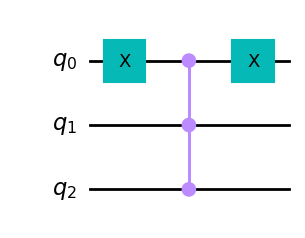

global phase: π
         ┌───┐   ┌───┐ ░ ┌───┐ ░ ┌───┐          ┌───┐      ░ ┌───┐
state_0: ┤ X ├─■─┤ X ├─░─┤ H ├─░─┤ X ├───────■──┤ X ├──────░─┤ H ├
         └───┘ │ └───┘ ░ ├───┤ ░ ├───┤       │  ├───┤      ░ ├───┤
state_1: ──────■───────░─┤ H ├─░─┤ X ├───────■──┤ X ├──────░─┤ H ├
               │       ░ ├───┤ ░ ├───┤┌───┐┌─┴─┐├───┤┌───┐ ░ ├───┤
state_2: ──────■───────░─┤ H ├─░─┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├─░─┤ H ├
                       ░ └───┘ ░ └───┘└───┘└───┘└───┘└───┘ ░ └───┘

In [35]:
#VARIABLES GLOBALES
marked_states=['110']
nroQubits=3
shots=10000
errorProbabilities = [
    0,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
]

#Se crea el operador de grover: oraculo + expansion de estado
oracle = grover_oracle(marked_states)
groverOp = GroverOperator(oracle, insert_barriers=True)

#Se calcula el numero optimo de iteraciones
optimal_num_iterations = math.floor(
    math.pi / 4 * math.sqrt(2**groverOp.num_qubits / len(marked_states))
)
display(oracle.draw('mpl'))
groverOp.decompose().draw()

##  1. Simulaciones 
#### Errores de Pauli en compuertas de 1 qubit
# 76e96489455b765e6e2a25c4ff28b6f5ade8c577d05c7c45d31ec96873a84d97d7ebea3859b19b5e1a9bd8dc6e4ffdd0dbcc4d362399a0ca5b2129daab6faaf1

PROBABILIDAD DE ERROR:  0
noise model:  NoiseModel: Ideal


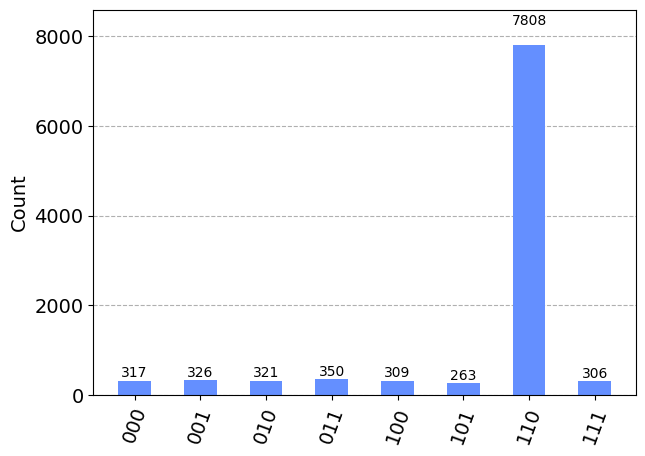

PROBABILIDAD DE ERROR:  0.05
noise model:  NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'x', 'rz']
  All-qubits errors: ['sx', 'rz', 'x']


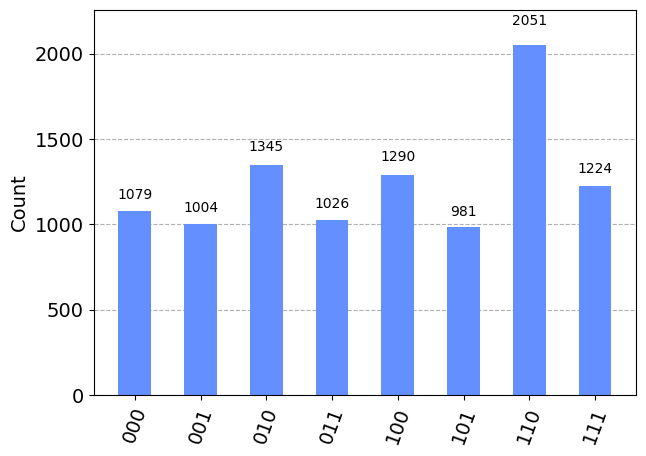

PROBABILIDAD DE ERROR:  0.1
noise model:  NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'x', 'rz']
  All-qubits errors: ['sx', 'rz', 'x']


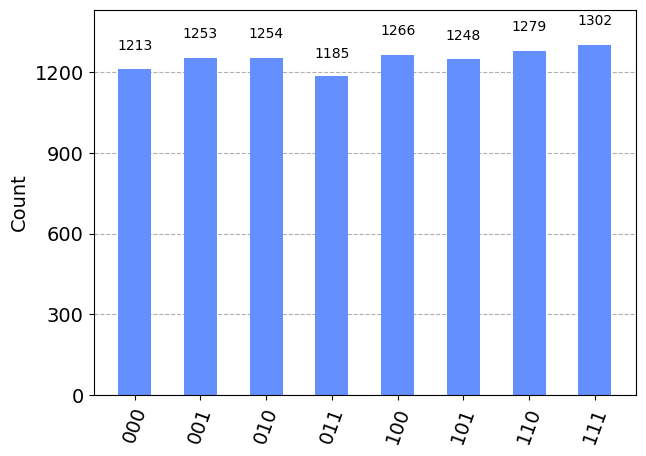

PROBABILIDAD DE ERROR:  0.15
noise model:  NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'x', 'rz']
  All-qubits errors: ['sx', 'rz', 'x']


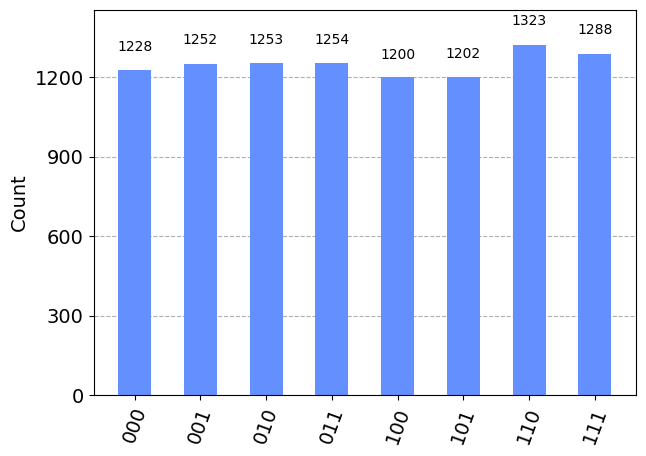

PROBABILIDAD DE ERROR:  0.2
noise model:  NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'x', 'rz']
  All-qubits errors: ['sx', 'rz', 'x']


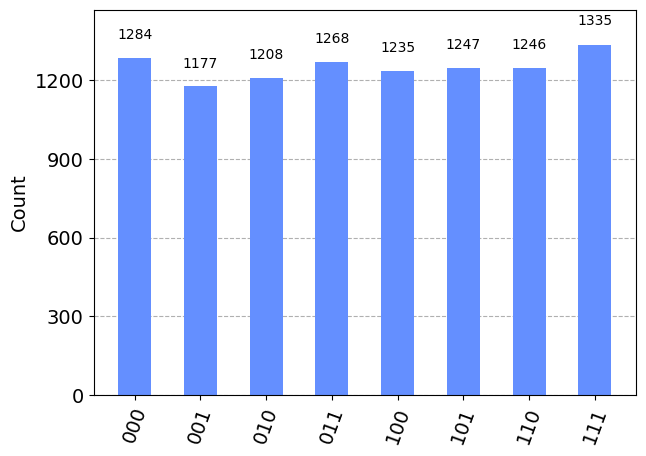

PROBABILIDAD DE ERROR:  0.25
noise model:  NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'x', 'rz']
  All-qubits errors: ['sx', 'rz', 'x']


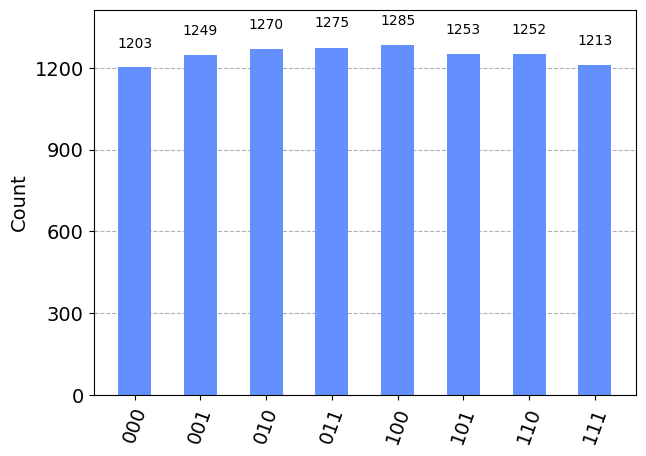

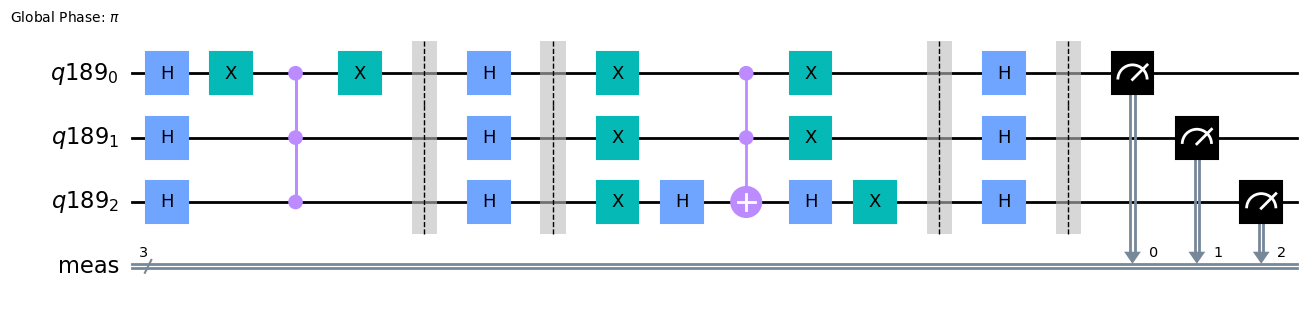

In [23]:
results = []
for i in errorProbabilities:
    #ALGORITMO
    print('PROBABILIDAD DE ERROR: ',i)
     
    noiseModel = NoiseModel()
    noiseModel = add_pauli_error(noiseModel,i/2,i/2,['sx','rz','x'])
    print('noise model: ',noiseModel)
        
    qr = QuantumRegister(nroQubits)
    qc = QuantumCircuit(qr)
    qc.h(qr)
    qc.compose(groverOp.decompose(), inplace=True)
    qc.measure_all()
    #display(qc.data)
    
    #EJECUCION
    sim_noise = AerSimulator(noise_model=noiseModel)
    circ_tnoise = transpile(qc, sim_noise)
    result_bit_flip = sim_noise.run(circ_tnoise,shots=shots).result()
    counts_bit_flip = result_bit_flip.get_counts(0)
    display(plot_histogram(counts_bit_flip))
        
    results.append(counts_bit_flip)
display(qc.draw("mpl"))

In [22]:
#CALCULO DE PROBABILIDADES DE EXITO PARA CADA EXPERIMENTO
successCounts1=[]
for i in results:
    currentCount = 0
    for j in marked_states:
        currentCount = currentCount + i[j]
    successCounts1.append(currentCount/shots)
print(successCounts1)

[0.7755, 0.2081, 0.1335, 0.1319, 0.1219, 0.1245]


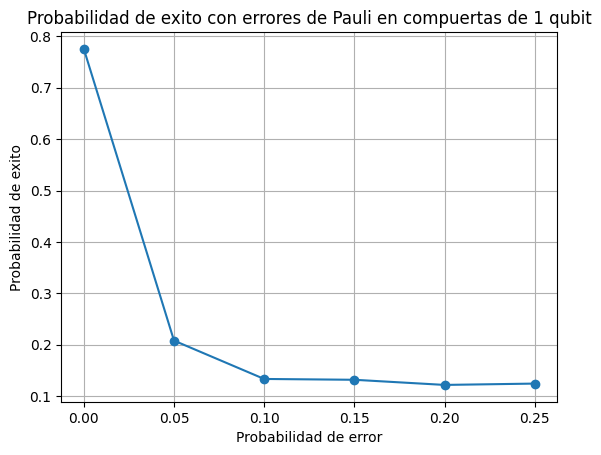

In [24]:
# Crear el gráfico
plt.plot(errorProbabilities, successCounts1, marker='o', linestyle='-')

# Etiquetas de los ejes
plt.xlabel('Probabilidad de error')
plt.ylabel('Probabilidad de exito')

# Título del gráfico
plt.title('Probabilidad de exito con errores de Pauli en compuertas de 1 qubit')

# Mostrar el gráfico
plt.grid(True)
plt.show()

#### Errores de Pauli en compuertas de 2 qubits

PROBABILIDAD DE ERROR:  0
noise model:  NoiseModel: Ideal


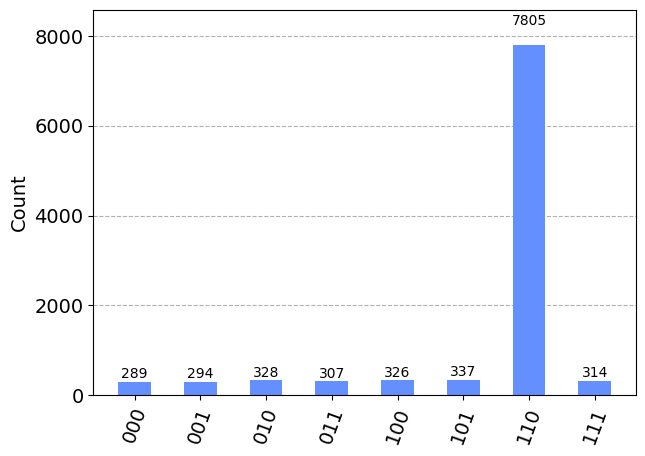

PROBABILIDAD DE ERROR:  0.05
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cy', 'cx', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


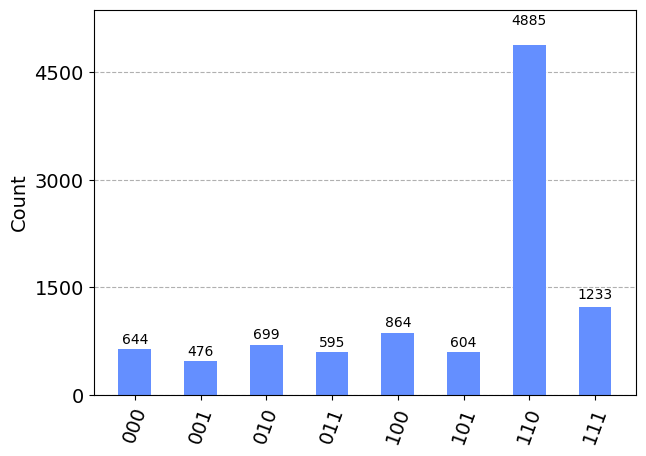

PROBABILIDAD DE ERROR:  0.1
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cy', 'cx', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


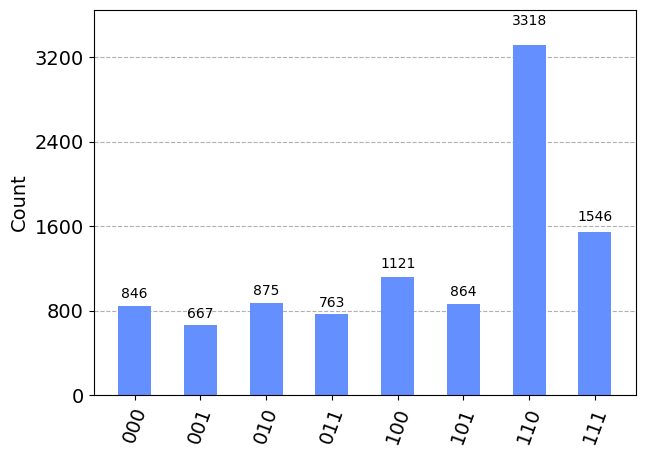

PROBABILIDAD DE ERROR:  0.15
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cy', 'cx', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


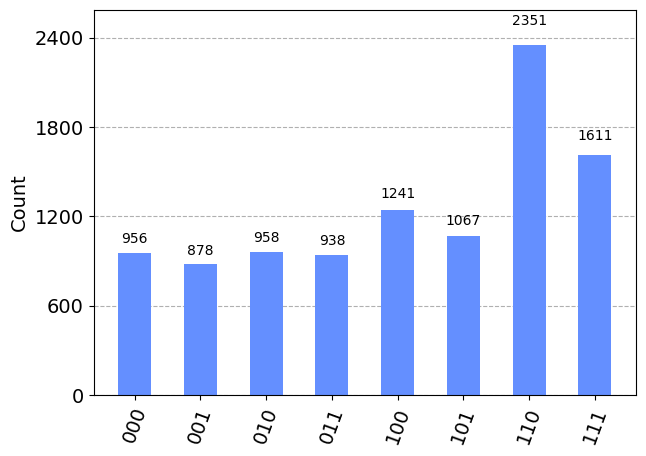

PROBABILIDAD DE ERROR:  0.2
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cy', 'cx', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


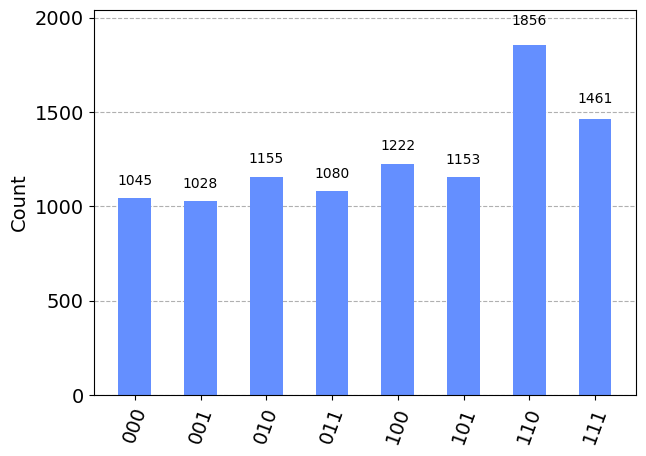

PROBABILIDAD DE ERROR:  0.25
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cy', 'cx', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


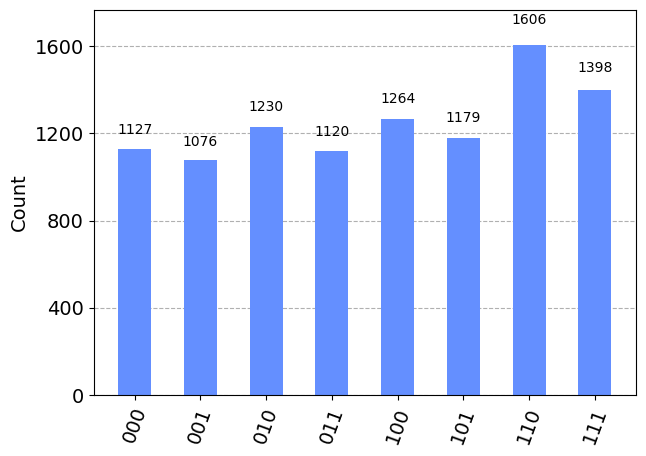

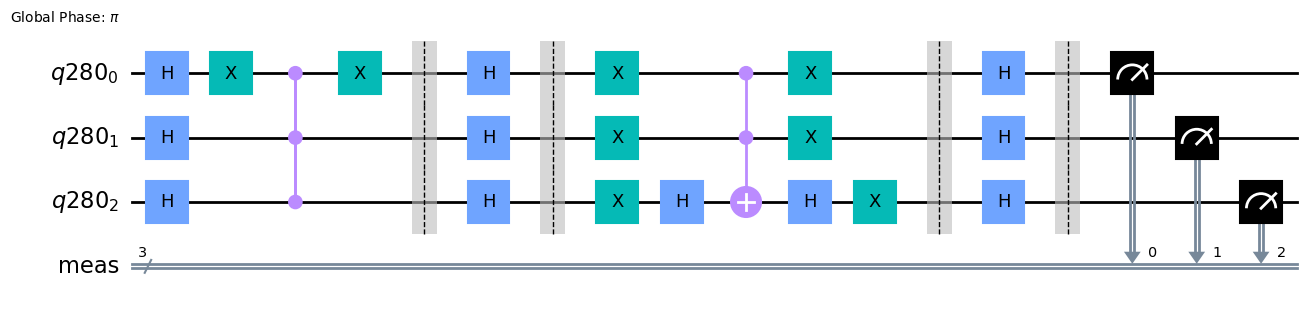

In [27]:
results = []
for i in errorProbabilities:
    #ALGORITMO
    print('PROBABILIDAD DE ERROR: ',i)
    
    noiseModel = NoiseModel()
    noiseModel = add_controlled_pauli_error(noiseModel,i/2,i/2,['cx','cy','cz'])
    basisGates=noiseModel.basis_gates
    print('noise model: ',noiseModel)
        
    qr = QuantumRegister(nroQubits)
    qc = QuantumCircuit(qr)
    qc.h(qr)
    qc.compose(groverOp.decompose(), inplace=True)
    qc.measure_all()
    #display(qc.data)
    
    #EJECUCION
    sim_noise = AerSimulator(noise_model=noiseModel)
    circ_tnoise = transpile(qc, sim_noise)
    result_bit_flip = sim_noise.run(circ_tnoise,shots=shots).result()
    counts_bit_flip = result_bit_flip.get_counts(0)
    display(plot_histogram(counts_bit_flip))
        
    results.append(counts_bit_flip)
display(qc.draw("mpl"))

In [28]:
#CALCULO DE PROBABILIDADES DE EXITO PARA CADA EXPERIMENTO
successCounts2=[]
for i in results:
    currentCount = 0
    for j in marked_states:
        currentCount = currentCount + i[j]
    successCounts2.append(currentCount/shots)
print(successCounts2)

[0.7805, 0.4885, 0.3318, 0.2351, 0.1856, 0.1606]


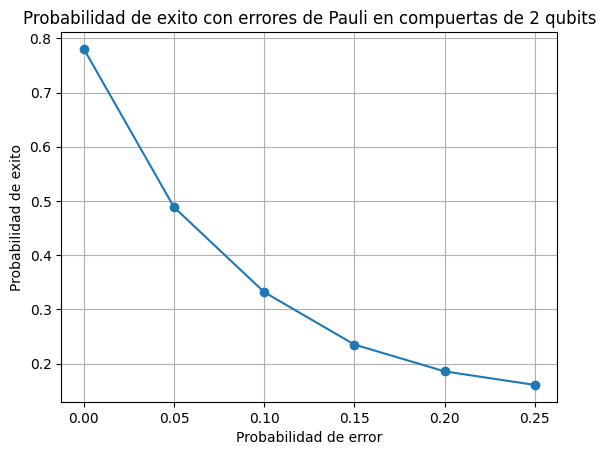

In [29]:
# Crear el gráfico
plt.plot(errorProbabilities, successCounts2, marker='o', linestyle='-')

# Etiquetas de los ejes
plt.xlabel('Probabilidad de error')
plt.ylabel('Probabilidad de exito')

# Título del gráfico
plt.title('Probabilidad de exito con errores de Pauli en compuertas de 2 qubits')

# Mostrar el gráfico
plt.grid(True)
plt.show()

## 2. Ejecución quantum lab

In [38]:
#ALGORITMO      
qr = QuantumRegister(nroQubits)
qc = QuantumCircuit(qr)
qc.h(qr)
qc.compose(groverOp.decompose(), inplace=True)
qc.measure_all()
#display(qc.draw("mpl"))
#display(qc.data)
    
#EJECUCION
qc_transpiled = transpile(qc,ibm_nairobi_backend)
result = ibm_nairobi_backend.run(qc_transpiled,shots=shots).result()
counts = result.get_counts(0)

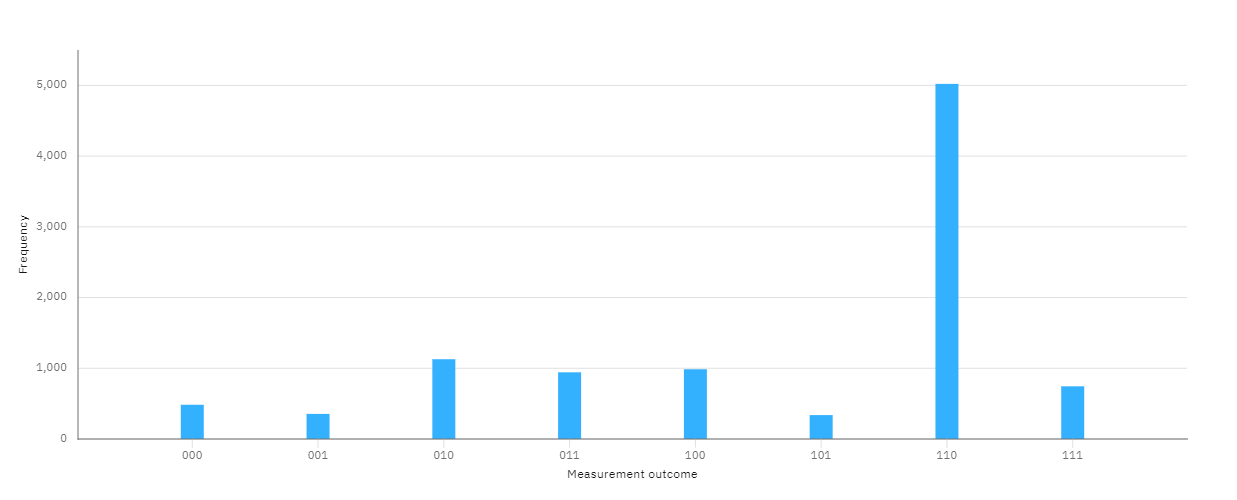

In [39]:
from PIL import Image
img = Image.open(r'E:\Proyecto Quantum Quipu\QuantumQuipu_NoiseAndNativeGates\Histogramas_SobreHardware\cmk173waa7w0008pehx0_histogram.png')
display(img)